## Description of the project

ScRNA-seq experiment return matrices in which for each cell we assign the RNA signal from
many thousands of genes (in our task X) and the signal from several dozen several surface proteins
(in our task, for simplicity, we chose a single protein CD361, y).
According to the central dogma of biology, we know that genetic information flows from RNA
to proteins. Thus, we should expect a correlation between the amount of protein and the expression
of the gene coded by that protein. For technical and biological reasons, this relationship often
degenerates. The problem in this task is to predict the signal from surface proteins on the basis
of gene expression. Predicting the protein abundance signal is crucial to most publicly available
collections for which only RNA matrix is available. Analysis of the signal about gene expression and
the number of surface proteins significantly facilitates the identification and naming process of the
cells in the sample.
The data comes from the bone marrow of human donors. The collected cells are mostly cells
of the immune system. Correct identification of T cells based on both types of reads in a set of
this type could be the basis for developing targeted therapies cancer (for the curious: CAR T cell
therapy).

Our goal is to predict the amount of certain protein types with a given data using machine learning algorithms



## The data
• X train.csv and X test.csv, containing RNA matrices. Each row corresponds to a cell,
the column is the gene, while the values are the levels of expressions. Those files contain our
potential independent variables (regressors).

• y train.csv, corresponding to the amount of a certain type of surface protein in cells, our
dependent variable (response) related to the regressors from X train.csv.



In [ ]:
!pip install optuna
!pip install scikit-optimize


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 4.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 3.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
import optuna
import scipy.stats as stats
from sklearn.decomposition import PCA



Opening of the datasets and creation of a new test set for the independent variable $y$.

In [ ]:
ytrain = pd.read_csv('Y_train.csv')
xtest = pd.read_csv('X_test.zip')
xtrain = pd.read_csv('X_train.zip')
ytest = ytrain.sample(n=761)

We look for NaN values throughout the entire dataset

In [ ]:
xtest.isna().sum().sum(),ytrain.isna().sum().sum(),xtrain.isna().sum().sum()

(0, 0, 0)

We open the datasets and check for the Null values. In this particular case there are none for any of the three sets. We do not have to tranform the data to fit missing values then.


In [ ]:
xtest.describe(),xtrain.describe(),ytrain.describe(),ytest.describe()

(          A2M-AS1        AAAS       AAGAB       AAMDC        AAMP    AASDHPPT  \
 count  761.000000  761.000000  761.000000  761.000000  761.000000  761.000000   
 mean     0.077802    0.047250    0.063387    0.056340    0.113795    0.125255   
 std      0.276815    0.216376    0.228721    0.207310    0.361885    0.309628   
 min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
 25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
 50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
 75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
 max      1.978006    2.995203    3.252008    1.447871    3.570888    2.875560   
 
              AATF      ABALON       ABCA5       ABCA7  ...      ZSWIM3  \
 count  761.000000  761.000000  761.000000  761.000000  ...  761.000000   
 mean     0.154524    0.024612    0.038371    0.066529  ...    0.006952   
 std      0.313385    0.250298    0

Using the describe function to see important statistics for every column of the dataset. It being so big is hard to analyise the releation between statistics.

In [ ]:
##Scaling the datasets
ytrain = stats.zscore( ytrain)
xtrain=stats.zscore(xtrain)
xtest = stats.zscore(xtest)


Scaling of the data to check if the dependent variable follows an specific distribution mainly normality which is very characteristic and easy to manage.

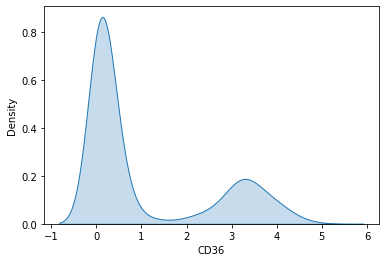

In [ ]:
sns.kdeplot(ytrain['CD36'], shade=True)


Ploting the data as a function with the kernel density plot we see two large peaks. The dependent variable follows a bimodal function where most of the data clusters around $[-1,0]$ values. This is obviously for standarize factors.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f013cea3d60>]],
      dtype=object)

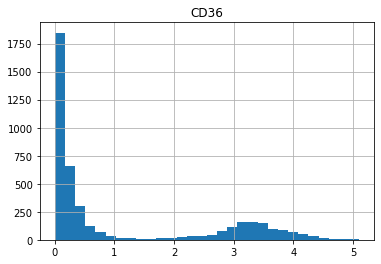

In [ ]:
ytrain.hist(bins = 30)


Creation of a correlation array with all the subsequent correlation between each variable and the dependent variable $y$

In [ ]:
corr = []##Computation of the correlation of each variable with the dependent variable
for i in range(6938):
  corre=ytrain['CD36'].corr(xtrain.iloc[:,i])
  corr.append(corre)
corr


[-0.11909544020659321,
 0.08363206405035412,
 -0.007509106967405284,
 0.036832430667424525,
 0.02529640598777521,
 -0.07265528554990412,
 -0.10440820026917821,
 0.15678263712747054,
 -0.08980648193292894,
 0.019689360172958265,
 -0.11532086979432717,
 0.32326745039085825,
 0.24114123886793914,
 0.058948034273155446,
 -0.07535332976800911,
 -0.04968264122788857,
 -0.023922835749019745,
 0.10922601988886574,
 0.07220512263865833,
 -0.11788577865481266,
 -0.05200873007485417,
 -0.12461753605497357,
 -0.08460485322168283,
 0.022439432925639057,
 -0.04758707334833362,
 0.20683279731080587,
 -0.0235821113404512,
 -0.03514422900354793,
 0.0033964334982882305,
 0.10980120645217925,
 -0.29788670404433376,
 0.007662697327095276,
 0.08071277733097657,
 0.09907537252392157,
 0.2575392556247379,
 -0.08225220258365332,
 -0.0363611593779413,
 0.004991871448832298,
 -9.198857399079554e-05,
 -0.26421651617989045,
 -0.13368912294361895,
 -0.0167792529239153,
 0.24286598327823403,
 0.12766491178399117,
 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


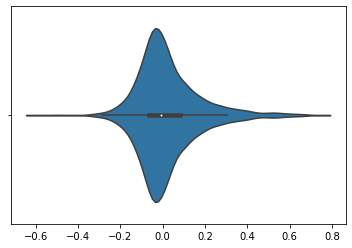

In [ ]:
sns.violinplot(corr)

The violin plot gives information about the most probable values that the correlation coefficients will take. In this particular case, coefficients group around 0 which means that most variables are not highly related. Moreover, the highest peak is formed in the negative side more than positive meaning there is a slight variation and variables tend to negatively correlate to de estimation variable


In [ ]:
l = []
for i in range(len(corr)):
  if corr[i]>0.5095:
    l.append(i)

mostcorr= xtrain.iloc[:,l]

Here is a heatmap of the most coreelated variables. We can detect high values of correlation throughout the entire corr matrix. It is extremely surprising since almost none of them go lower than 0.5.

Due to the amount of variables "100" it is very hard to distinguish between values, however the colours of the map show us strong relation.

The correlations are all positive

In [ ]:
sns.set(rc={'figure.figsize':(300,300)}) ##Setting the size of the matrix
sns.heatmap(mostcorr.corr(method = 'pearson'),annot=True,cmap='cividis')

# Lasso and Ridge regression with Elastic Net

ElasticNet is a machine learning algorithm that combines Lasso and Ridge regression. It is implemented in order to overcome both of this models limitations to achive a better prediction.
The parameters are found optimizing a function that has two factors (one for Lasso and one for Ridge) through a parameter called L1_ratio.


$\hat{\beta} = argmin_{\beta}(\|\|y - X\beta\|\|^2 + (1-\lambda)\| \beta\|_{2} +\lambda\|\beta\|_{1})$

With this function if the $\lambda$ parameter is 1 the ElastiNet function becomes Lasso, while if it is 0 it is the ridge regression. That way the $l1\; ratio : \lambda$ takes values from 0 to 1 and ElasticNet is a mixture of the two regressions.

In [ ]:
from skopt.searchcv import BayesSearchCV
from skopt.space import Real,Categorical,Integer


We create a grid of parametersfor l1_ratio and alpha including ${{0,1}}$ that determines the lasso and ridge regressions.


In [ ]:
elastic = ElasticNet()
opt = BayesSearchCV(elastic,param,n_iter = 50)

In [ ]:
param = {'alpha':[0,1,2,3,4,5,6,7,8,15],'l1_ratio':[0,0.1,0.5,0.8,1]}

We fit the model on our data

In [ ]:
opt.fit(xtrain,ytrain)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.006e+02, tolerance: 7.167e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.999e+02, tolerance: 7.391e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.

BayesSearchCV(estimator=ElasticNet(),
              search_spaces={'alpha': [0, 1, 2, 3, 4, 5, 6, 7, 8, 15],
                             'l1_ratio': [0, 0.1, 0.5, 0.8, 1]})

We compute the score of the bayesian cross validation algorithm it is a very high percentage of variance explained by the R2 estimator so the model fits very well

In [ ]:
opt.score(xtest,ytest)

-0.8254112230258228

This is are the best estimators for the ElasticNet model grid. Since the l1_ratio is 0 the output of best hyperparameters is a Ridge regression.


In [ ]:
opt.best_estimator_

ElasticNet(alpha=1, l1_ratio=0.0)

Index that was chosen by the cross validation

In [ ]:
opt.best_index_

11

Score of the best iteration that was chosen for the cross validation result

In [ ]:
opt.best_score_

0.9246790797633764

Checking the score of the cross validation for the test subsets

In [ ]:
opt.score(xtest,ytest)

-0.8759314397914475

# Performing Random Forest estimation and tuning

We create a Random Forest hyperparameter tuning with cross validation. Due to the big amount of computations and the large time it takes we use Bayes cross validation that is a much more feasable tuning algorithm.
Our parameters to be estimated are: number of estimators, maximum depth of the regressions, maximum number of features

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
parameters = {
    "n_estimators": [100, 200, 300],
    "max_depth": [1,5,9],
    'max_features':[1,3,5]}
opt2 = BayesSearchCV(rf,parameters,n_iter = 50)

We fit the model with the training data given for the assingment. Xtrain,Ytrain

In [ ]:
opt2.fit(xtrain,ytrain)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

BayesSearchCV(estimator=RandomForestRegressor(),
              search_spaces={'max_depth': [1, 5, 9], 'max_features': [1, 3, 5],
                             'n_estimators': [100, 200, 300]})

The best parameters selected from our parameter grid.

In [ ]:
opt2.best_estimator_

RandomForestRegressor(max_depth=9, max_features=5, n_estimators=200)

Score of the test fold of our dataset with the given Random Forest Regressor model.

In [ ]:
opt2.score(xtest,ytest)

-0.4327499793132479

We compute the tubular summary in the form of dataset for the ElasticNet regression and Random Forest regression.
With the data for each split of the cross validation and the characteristics of each iterations
Each row is an iteration with the subsequent characteristics :mean and std fit time,mean and std score time, the explained parameters, the test score for each split of the cross validation with the mean test score,std, and rank score of the test.

In each iteration the data is divided into 4 cross validtion folds and analyised. From the subdivision we take a test and a train subset and feature the subsequent statistics in the tubular summary.

Out of all iterations we take the best possible outcome and check wich hyperparameters are the ones that create the best scores


In [ ]:
tub_sum_elastic=pd.DataFrame(opt.cv_results_)
tub_sum_elastic

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0        0.395644      0.024417         0.089781        0.017307           7   
1       33.559147      1.529621         0.088977        0.011153           3   
2        3.328377      0.289048         0.084978        0.003627           1   
3        1.167944      0.039470         0.085685        0.001550           4   
4        2.164217      0.050882         0.081414        0.002985           1   
5        0.386309      0.004227         0.084382        0.008936           6   
6        0.391493      0.016582         0.081697        0.002629           8   
7        0.472598      0.031706         0.081757        0.006818           6   
8       42.862899      0.490513         0.082233        0.004094           5   
9        2.505004      0.036094         0.084294        0.005478           1   
10       1.409983      0.017642         0.092666        0.009912           3   
11       0.383693      0.012300         0.082220        0.002273           5   
12      32.412888      0.288230         0.086035        0.008642           1   
13      32.371289      0.235530         0.087536        0.009735           2   
14       1.331984      0.047349         0.083968        0.002941           0   
15      51.807944      0.453319         0.085486        0.005990          15   
16      38.398415      0.421238         0.088059        0.003554           4   
17       1.793307      0.028663         0.082603        0.002559           2   
18       0.634115      0.051321         0.082843        0.007069          15   
19      54.454770      5.588467         0.086747        0.004660           8   
20      52.982431      5.391726         0.082615        0.003633           7   
21      51.257344      4.667900         0.081113        0.001067           6   
22       0.961097      0.085422         0.084200        0.004020           7   
23       1.164874      0.103950         0.080834        0.001587           5   
24       0.887945      0.086277         0.082911        0.004750           8   
25      36.105567      2.924316         0.082969        0.005254           1   
26      36.120411      2.906073         0.095051        0.024939           1   
27      35.962347      3.107021         0.083443        0.002522           1   
28      36.025754      3.081241         0.084937        0.002985           1   
29      35.872037      3.021469         0.084673        0.004891           1   
30      35.966581      2.854506         0.082948        0.003456           1   
31      35.944516      2.907430         0.081198        0.003941           1   
32       4.700580      0.524741         0.080603        0.001847           1   
33      36.173092      3.285862         0.085525        0.004134           1   
34      35.949982      3.055087         0.081987        0.004657           1   
35      35.863558      3.050230         0.097720        0.026824           1   
36      35.890624      3.022931         0.083961        0.006052           1   
37      36.117920      2.929956         0.084238        0.002792           1   
38      36.080804      3.174136         0.082234        0.002823           1   
39      35.940199      3.042285         0.083960        0.003050           1   
40      35.903080      3.027311         0.083208        0.003848           1   
41      35.994632      2.891012         0.085581        0.003128           1   
42      35.996783      3.152814         0.082635        0.003322           1   
43      36.433080      3.521617         0.088711        0.008973           1   
44      36.150300      3.162029         0.084249        0.003511           1   
45      36.029233      3.121225         0.083819        0.003049           1   
46      36.080546      2.887998         0.085304        0.007795           1   
47      36.071186      3.196326         0.088159        0.006303           1   
48      36.184063      3.307999         0.084128        0.001910           1   
49  

This is the tubular summary for the RandomForest Regression. With the corresponding cross validation results that have been described earlier

In [ ]:
tub_sum_rf=pd.DataFrame(opt2.cv_results_)
tub_sum_rf

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.616111      0.094105         0.114747        0.024305   
1        0.384331      0.011167         0.068040        0.001737   
2        0.494703      0.029964         0.077514        0.008894   
3        0.472196      0.008067         0.076206        0.001953   
4        0.369084      0.017668         0.066095        0.004541   
5        0.370225      0.007013         0.062056        0.001113   
6        0.978382      0.008935         0.093614        0.007941   
7        0.617103      0.013432         0.089598        0.004273   
8        0.582866      0.010720         0.086311        0.003235   
9        0.288798      0.009933         0.064227        0.006865   
10       0.948330      0.012443         0.084253        0.001177   
11       0.416653      0.015026         0.069912        0.003191   
12       1.413663      0.023003         0.106080        0.003476   
13       0.587622      0.016590         0.074338        0.005229   
14       1.019425      0.016328         0.090672        0.004934   
15       1.434927      0.021152         0.106732        0.004489   
16       1.007267      0.025762         0.088112        0.003087   
17       0.450179      0.014425         0.072533        0.007414   
18       1.000142      0.032911         0.090245        0.004643   
19       1.424833      0.030532         0.108578        0.002815   
20       0.584781      0.012093         0.073465        0.006713   
21       1.415342      0.012868         0.110631        0.006082   
22       1.013661      0.012209         0.088435        0.002417   
23       1.403229      0.022676         0.107736        0.004873   
24       1.399939      0.011408         0.105432        0.003385   
25       0.584205      0.014941         0.072467        0.006316   
26       0.991282      0.019293         0.088023        0.003059   
27       0.585610      0.009574         0.070115        0.001876   
28       1.010904      0.026089         0.088447        0.004787   
29       1.419854      0.042311         0.105582        0.003395   
30       1.412351      0.030254         0.112927        0.004539   
31       1.000048      0.019158         0.088233        0.001987   
32       1.405503      0.018807         0.108122        0.005370   
33       0.579927      0.005175         0.073734        0.006114   
34       1.394536      0.016478         0.108926        0.007977   
35       0.582509      0.015934         0.071580        0.004093   
36       0.997001      0.018835         0.088570        0.002535   
37       1.406067      0.032101         0.113679        0.012343   
38       1.384453      0.007755         0.109146        0.003033   
39       0.984776      0.021369         0.090901        0.003409   
40       1.403813      0.018456         0.104312        0.002812   
41       0.983097      0.015861         0.090285        0.003899   
42       0.577894      0.010770         0.073198        0.004315   
43       0.977641      0.016664         0.094766        0.004320   
44       0.982208      0.017814         0.090869        0.002638   
45       1.389966      0.017755         0.106948        0.004313   
46       0.573232      0.008086         0.070068        0.001062   
47       0.996580      0.016249         0.090944        0.005279   
48       1.389741      0.022026         0.112036        0.005238   
49       1.406384      0.027463         0.104720        0.003084   

   param_max_depth param_max_features param_n_estimators  \
0                5                  3                100   
1                9                  1                100   
2                9                  3                100   
3                5                  1                200   
4                5                  3                100   
5                5                  3                100   
6                9                  5                200   
7                5                  1                30

We compute now the MSE, RMSE and the MAE for both the test and the train set. As well as the R^2 for the test set to check for overfitting in the data analyisis

In [ ]:
ypredict = opt.predict(xtrain)
ypredictest=opt.predict(xtest)

This are the values for the ElasticNet model. We see that the MSE for the training set is particularly low taking into account that the dataset is very large and the difference with the test MSE is not very large.
However in the case of MAE the difference is indeed a little bigger RESULTING IN overfitting. However the value of MAE is lower in the training set that the true MSE, which could mean some big errors since it is more penalysed in the MSE due to the useof the square.



In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(ytrain, ypredict)
mse = mean_squared_error(ytrain, ypredict)
rmse = sqrt(mse)
maetest = mean_absolute_error(ytest, ypredictest)
msetest = mean_squared_error(ytest, ypredictest)
r2 = r2_score(ytest, ypredictest)
mse,mae,msetest,maetest,r2

(0.11758181062802375,
 0.23401692631088394,
 3.9334178647709863,
 1.3648606164479706,
 -0.8254112230258228)

In [ ]:
ypredictrf=opt2.predict(xtrain)
ypredictestrf = opt2.predict(xtest)

In [ ]:
from statsmodels.api import adjusted_r_squared

The results for the Random Forest Regression is similar.
There is a bigger difference between the MAE values of the train and test data but the training MAE is higher than the training MSE (naturally since there is a square in the formula).
Values are higher for the Random Forest Regressor but the difference between training and testing is lower in terms of MAE and MSE.

This means that there is higher overfitting in ElasticNet model but it is more accurate for this model. Also the R2 is much higher, meaning that the accuaracy in predicting the variance is greater.

In general terms for the grid of parameters that has been set the Elastic Net model gives a better result ( the difference in possible overfitting is much lower than the difference in accuaracy for both models)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
maerf = mean_absolute_error(ytrain, ypredictrf)
mserf = mean_squared_error(ytrain, ypredictrf)
maetestrf = mean_absolute_error(ytest, ypredictestrf)
msetestrf = mean_squared_error(ytest, ypredictestrf)
r2rf = r2_score(ytest, ypredictestrf)
r2rff = r2_score(ytrain, ypredictrf)
mserf,maerf,msetestrf,maetestrf,r2rf

(0.34753395572035184,
 0.47493113026935085,
 3.1559956006146157,
 1.3289828163505737,
 -0.4483074534477316)

In [ ]:
rmse = sqrt(mse)
rmsetest = sqrt(msetest)
rmserf = sqrt(mserf)
rmsetestrf = sqrt(msetestrf)

## Performing PCA and AdaBoost regression with Crossvalidation

For this final part we need to choose a model in order to get a really good prediction of the regression.
Due to the size of the dataset and the enormous amount of zeros in the data we are going to perfor a PCA in order to stablish the most significant variables.

We perform a PCA with no number of estimators predefined in order to check for the parameters that explain the biggest variance.
This is computed through the variance ratio.

In [ ]:
count = xtrain.value_counts()[0].sum()
count

3981

In [ ]:
pca = PCA()
pca.fit(xtrain)
pca.transform(xtest)

array([[-6.02258409e+00, -4.65948417e+00, -2.50242823e+00, ...,
         1.42299754e-01,  9.98473532e-02, -1.02891929e-01],
       [-5.49848016e+00, -3.82629577e+00, -1.92401020e+00, ...,
        -4.85107610e-01, -2.71118129e-03,  1.66738985e-01],
       [-6.03261609e+00, -4.84589364e-01, -5.03533650e+00, ...,
         2.52830546e-02, -1.52778828e-01, -8.47103458e-02],
       ...,
       [ 4.30232721e+01,  3.67813206e-01, -2.34484138e-01, ...,
        -4.59558449e-01,  2.84247958e-01,  9.00114961e-02],
       [ 4.63959405e+01,  1.64903261e+00,  1.83218725e+00, ...,
        -1.55431223e-15,  4.82253126e-16,  1.53609764e-15],
       [-6.45103886e+00, -4.23852112e+00, -6.15317523e-01, ...,
         4.44201970e-01,  3.40421565e-02, -5.28275160e-01]])

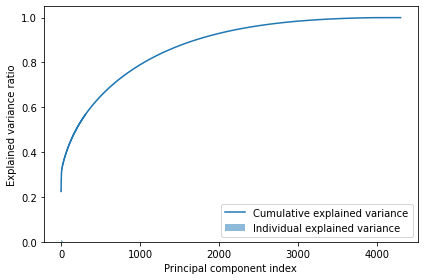

In [ ]:
explained = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(explained)

# Create the visualization plot
plt.bar(range(0,len(explained)), explained, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


We can see in the plot that around $80  \%$ of the data ( a very significant number of explained variance). We choose therefore 1500 estimators, 'columns',of the dataset.



In [ ]:
pca2 = PCA(n_components=1500)
pca2train=pca2.fit(xtrain)
data2 =pca2.transform(xtest)
data = pca2.fit_transform(xtrain)

In [ ]:
xdata = pd.DataFrame(data)
xdatatest=pd.DataFrame(data2)


Once the PCA is performed we convert the array of data into a completely new dataset with 1500 estimators 'columns'.

We choose for our final estimation the AdaBoostRegressor, a very useful optimization algorithm. For the hyperparameter tuning we use the BayesSearchCV, a bayesian optimization cross validation algorithm that is much quicker than others, specially for very large data like this one.

My choice of regressor comes from the fact that Xgboost regressor gives problems with the GPU when tuning its hyperparameters, while others regressors like Boosting, RandomForest and so on are less accurate and take too long to develop.
Nevertheless this particular algorithm does take very long (3 hours approximetely) but the grid of parameters selected is not too big and can be more easily calculated. Most of the other options are unfeasable with this amount of data.


In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from skopt.searchcv import BayesSearchCV
ada = AdaBoostRegressor(random_state=0)

In [ ]:
adaparameters = {'n_estimators':[30,40,50,70,90,110]}

In [ ]:
adaopt =  BayesSearchCV(estimator=ada,
                    search_spaces=adaparameters,cv=4)

In [ ]:
adaopt.fit(xdata,ytrain)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

BayesSearchCV(cv=4, estimator=AdaBoostRegressor(random_state=0),
              search_spaces={'n_estimators': [30, 40, 50, 70, 90, 110]})

We compute the Cross validation results for each of the iterations and convert into a dataframe just like we did with the ElasticNet Regression and the RandomForest.

In [ ]:
cvresults = pd.DataFrame(adaopt.cv_results_)
cvresults

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       96.289105      1.302784         0.411369        0.015504   
1       37.760658      0.316382         0.146728        0.002128   
2       63.619440      3.059584         0.260409        0.023082   
3      127.956243      6.553733         0.509387        0.015484   
4       80.383985      3.729471         0.324527        0.019748   
5      100.098396      5.944324         0.514263        0.170526   
6       78.547612      2.358003         0.297405        0.009045   
7       76.700504      1.229504         0.299605        0.006039   
8       37.371009      0.436765         0.142382        0.009362   
9       58.916731      2.100101         0.239343        0.010403   
10      47.717995      0.793445         0.186396        0.010267   
11      37.374643      0.429185         0.139549        0.008242   
12      37.077260      0.433768         0.132156        0.005229   
13     112.688570      1.972011         0.458123        0.017906   
14      37.290201      0.530147         0.136278        0.007094   
15      37.085976      0.367771         0.135078        0.010592   
16      37.139892      0.367517         0.138570        0.001788   
17      37.082454      0.398492         0.134352        0.005280   
18      47.238255      0.437911         0.174758        0.005369   
19      37.052825      0.487168         0.133330        0.009148   
20      37.139424      0.410616         0.143335        0.007568   
21      47.356184      0.489623         0.175823        0.011419   
22      37.095806      0.395781         0.129072        0.004243   
23      36.744785      0.415115         0.129293        0.007793   
24      36.830700      0.424971         0.128955        0.005145   
25      37.086714      0.330168         0.135667        0.007190   
26     113.277769      2.263213         0.477353        0.032107   
27      37.463701      0.612141         0.133229        0.006640   
28      94.877026      1.708034         0.369834        0.019377   
29      95.669770      2.055996         0.397124        0.024505   
30      38.210806      0.799792         0.146829        0.005672   
31      37.724724      0.561605         0.148904        0.008179   
32      96.216316      2.192959         0.393151        0.010372   
33      37.904462      1.173473         0.133289        0.000527   
34      76.871667      1.113093         0.284288        0.009747   
35     113.877505      2.287506         0.461761        0.023221   
36      76.567583      1.420320         0.285048        0.008333   
37      58.089906      1.308211         0.218849        0.004116   
38      37.377039      0.371726         0.131686        0.001810   
39      57.863229      1.085526         0.212574        0.006034   
40      76.886124      1.433303         0.299912        0.006108   
41      37.568252      0.142038         0.129007        0.003771   
42      77.242611      1.006159         0.304893        0.015604   
43      37.405925      0.408321         0.133361        0.005408   
44      95.712993      2.146067         0.380930        0.016145   
45      37.697412      0.545334         0.133983        0.001747   
46      37.421742      0.128294         0.141278        0.008271   
47      37.291763      0.464237         0.129849        0.003861   
48      94.633046      1.410351         0.365170        0.020423   
49      36.966114      0.379155         0.125515        0.008663   

   param_n_estimators                 params  split0_test_score  \
0                  90   {'n_estimators': 90}           0.778902   
1                  30   {'n_estimators': 30}           0.860967   
2                  50   {'n_estimators': 50}           0.809064   
3                 110  {'n_estimators': 110}           0.784340   
4                  70   {'n_estimators': 70}           0.790937   
5                  90   {'n_estimators': 90}           0.778902   
6                  70   {'n_estimators': 70}           0.790937   

Predicting the data and gettin the predictive parameters for the train and test data

In [ ]:
prediction = adaopt.predict(xdata)
predictiontest = adaopt.predict(xdatatest)


In [ ]:
import sys
np.set_printoptions(threshold=sys.maxsize)
prediction

array([0.67617766, 1.7992692 , 0.67617766, 0.67617766, 0.71145739,
       0.71145739, 0.7350869 , 0.54599615, 3.98299024, 0.57216373,
       0.57216373, 0.81450248, 3.54509119, 0.54599615, 0.61931935,
       0.67617766, 3.57052994, 3.04117227, 0.67617766, 0.57216373,
       3.40140446, 0.67617766, 0.67617766, 0.67617766, 2.98308531,
       0.49124587, 0.57216373, 0.78962061, 0.5891865 , 1.67440923,
       3.27832621, 0.545282  , 0.67617766, 0.5891865 , 0.67617766,
       0.61931935, 0.57216373, 0.61931935, 0.67617766, 0.78962061,
       0.67617766, 0.71145739, 0.67617766, 2.50504013, 0.57216373,
       0.67617766, 0.63659369, 0.71145739, 0.61931935, 1.19721941,
       0.81450248, 0.67617766, 0.67617766, 3.96822815, 0.63659369,
       0.67617766, 0.63659369, 0.78962061, 0.545282  , 2.96304816,
       3.98586086, 0.67617766, 0.61931935, 3.54509119, 0.71145739,
       0.71145739, 0.5891865 , 0.71145739, 3.27832621, 0.78962061,
       1.19721941, 0.67617766, 0.61931935, 0.67617766, 0.67617

In [ ]:
predictiontest

array([0.67617766, 0.67617766, 0.67617766, 0.5891865 , 0.5891865 ,
       3.40140446, 2.98497216, 2.98308531, 3.40140446, 3.98613307,
       2.5013783 , 0.67617766, 3.09148938, 0.67617766, 0.57216373,
       0.78962061, 0.67617766, 0.545282  , 0.61931935, 0.57216373,
       3.98586086, 0.67617766, 0.78962061, 0.67617766, 0.67617766,
       1.95123978, 0.78962061, 0.78962061, 1.20402895, 0.78962061,
       0.71145739, 0.63659369, 0.67617766, 0.67617766, 0.7350869 ,
       2.99763524, 3.39520154, 0.7350869 , 3.16644784, 0.545282  ,
       0.67617766, 0.63659369, 0.71145739, 1.7992692 , 3.54509119,
       3.31239823, 3.15934972, 0.57216373, 2.98308531, 0.7350869 ,
       0.67617766, 0.78962061, 0.57216373, 0.67617766, 0.78962061,
       0.78962061, 1.7992692 , 0.78962061, 0.67617766, 3.98299024,
       0.67617766, 2.88638713, 0.67617766, 0.78962061, 0.61931935,
       3.29971354, 0.7350869 , 1.32679991, 0.54599615, 0.81450248,
       3.39145572, 0.61931935, 0.61931935, 2.98308531, 0.57216

Computing the consistent statistics to check the goodness of fit of the AdaBoost regression.
There is no big difference between the MSE in the test and train data which means that the overfitting is not large.
Also the MAE values take reasonable parameters and the error is not to high.
The R2 takes an average value which could indeed mean that the explanatory capacity of the estimator is not very high

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
maeada = mean_absolute_error(ytrain, prediction)
mseada = mean_squared_error(ytrain, prediction)
maetestada = mean_absolute_error(ytest, predictiontest)
msetestada = mean_squared_error(ytest, predictiontest)
r2ada = r2_score(ytest, predictiontest)
mseada,maeada,msetestada,maetestada,r2ada

(0.2900745514268871,
 0.4831829465641017,
 3.2600486551057437,
 1.3787404491092883,
 -0.52254590384105)